In [100]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re as re
import matplotlib.pyplot as plt

# standardize the vaiable
from sklearn.preprocessing import StandardScaler

# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# building the models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Keras specific
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical 

# validation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report

#To ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/train.csv")
all_data = [train_data, test_data]

In [4]:
#Feature 1: Pclass
print( train_data[["Pclass","Survived"]].groupby(["Pclass"], as_index = False).mean() )

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


If a person is an important person, they have more chance to survive than others.

In [5]:
#Feature 2: Sex
print( train_data[["Sex","Survived"]].groupby(["Sex"], as_index = False).mean() )

      Sex  Survived
0  female  0.742038
1    male  0.188908


"Lady first!" Female and children were survived during the accident.

In [6]:
#Feature 3: Family Size
for data in all_data:
    data['family_size'] = data['SibSp'] + data['Parch'] + 1
print( train_data[["family_size","Survived"]].groupby(["family_size"], as_index = False).mean() )

   family_size  Survived
0            1  0.303538
1            2  0.552795
2            3  0.578431
3            4  0.724138
4            5  0.200000
5            6  0.136364
6            7  0.333333
7            8  0.000000
8           11  0.000000


"SibSp" and "Parch" are not meaningful individually so I made them one family size. 4 family size have the thighest survival rate.

In [7]:
#Feature 3.1: Is alone?
for data in all_data:
    data['is_alone'] = 0
    data.loc[data['family_size'] == 1, 'is_alone'] = 1
print (train_data[['is_alone', 'Survived']].groupby(['is_alone'], as_index=False).mean())

   is_alone  Survived
0         0  0.505650
1         1  0.303538


In [8]:
#Feature 4: Embarked
for data in all_data:
    data['Embarked'] = data['Embarked'].fillna('S')
print( train_data[["Embarked","Survived"]].groupby(["Embarked"], as_index = False).mean() )

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


From which place a passenger embarked has something to do with survival

In [9]:
#Feature 5: Fare
for data in all_data:
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())
train_data['category_fare'] = pd.qcut(train_data['Fare'], 4)
print( train_data[["category_fare","Survived"]].groupby(["category_fare"], as_index = False).mean() )

     category_fare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


There are many missing data in "Fare" column so I impute the median value of the fare to the missing value.

In [10]:
for data in all_data:
    age_avg  = data['Age'].mean()
    age_std  = data['Age'].std()
    age_null = data['Age'].isnull().sum()

    random_list = np.random.randint(age_avg - age_std, age_avg + age_std , size = age_null)
    data['Age'][np.isnan(data['Age'])] = random_list
    data['Age'] = data['Age'].astype(int)

train_data['category_age'] = pd.cut(train_data['Age'], 5)
print( train_data[["category_age","Survived"]].groupby(["category_age"], as_index = False).mean() )

    category_age  Survived
0  (-0.08, 16.0]  0.532110
1   (16.0, 32.0]  0.352809
2   (32.0, 48.0]  0.373541
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


In [11]:
import re

#Feature 7: Name
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\. ', name)
    if title_search:
        return title_search.group(1)
    return ""

for data in all_data:
    data['title'] = data['Name'].apply(get_title)

for data in all_data:
    data['title'] = data['title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],'Rare')
    data['title'] = data['title'].replace('Mlle','Miss')
    data['title'] = data['title'].replace('Ms','Miss')
    data['title'] = data['title'].replace('Mme','Mrs')
    
print(pd.crosstab(train_data['title'], train_data['Sex']))
print("----------------------")
print(train_data[['title','Survived']].groupby(['title'], as_index = False).mean())

Sex     female  male
title               
Master       0    40
Miss       185     0
Mr           0   517
Mrs        126     0
Rare         3    20
----------------------
    title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


We finished cleaning our features now. Let's move on the next steps.

In [12]:
#Map Data
for data in all_data:

    #Mapping Sex
    sex_map = { 'female':0 , 'male':1 }
    data['Sex'] = data['Sex'].map(sex_map).astype(int)

    #Mapping Title
    title_map = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Rare':5}
    data['title'] = data['title'].map(title_map)
    data['title'] = data['title'].fillna(0)

    #Mapping Embarked
    embark_map = {'S':0, 'C':1, 'Q':2}
    data['Embarked'] = data['Embarked'].map(embark_map).astype(int)

    #Mapping Fare
    data.loc[ data['Fare'] <= 7.91, 'Fare']                            = 0
    data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare'] = 1
    data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare']   = 2
    data.loc[ data['Fare'] > 31, 'Fare']                               = 3
    data['Fare'] = data['Fare'].astype(int)

    #Mapping Age
    data.loc[ data['Age'] <= 16, 'Age']                       = 0
    data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age'] = 1
    data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age'] = 2
    data.loc[(data['Age'] > 48) & (data['Age'] <= 64), 'Age'] = 3
    data.loc[ data['Age'] > 64, 'Age']                        = 4

#Feature Selection
#Create list of columns to drop
drop_elements = ["Name", "Ticket", "Cabin", "SibSp", "Parch", "family_size"]

#Drop columns from both data sets
train_data = train_data.drop(drop_elements, axis = 1)
train_data = train_data.drop(['PassengerId','category_fare', 'category_age'], axis = 1)
test_data = test_data.drop(drop_elements, axis = 1)

#Print ready to use data
print(train_data.head(10))

   Survived  Pclass  Sex  Age  Fare  Embarked  is_alone  title
0         0       3    1    1     0         0         0      1
1         1       1    0    2     3         1         0      3
2         1       3    0    1     1         0         1      2
3         1       1    0    2     3         0         0      3
4         0       3    1    2     1         0         1      1
5         0       3    1    2     1         2         1      1
6         0       1    1    3     3         0         1      1
7         0       3    1    0     2         0         0      4
8         1       3    0    1     1         0         0      3
9         1       2    0    0     2         1         0      3


In [13]:
print(train_data.head())

   Survived  Pclass  Sex  Age  Fare  Embarked  is_alone  title
0         0       3    1    1     0         0         0      1
1         1       1    0    2     3         1         0      3
2         1       3    0    1     1         0         1      2
3         1       1    0    2     3         0         0      3
4         0       3    1    2     1         0         1      1


In [63]:
#Prediction
#Train and Test data
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]
X_test  = test_data.drop(["PassengerId","Survived"], axis=1).copy()
Y_test = test_data["Survived"]

In [98]:
from collections import Counter

# count examples in each class
counter = Counter(Y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 1.605


# Logistic Regression

In [64]:
logmodel = LogisticRegression()
logmodel.fit(X_train, Y_train)
Y_pred_log = logmodel.predict(X_test)
accuracy = round(logmodel.score(X_train, Y_train) * 100, 2)
print("Model Accuracy: ",accuracy)

Model Accuracy:  80.36


In [65]:
print("Accuracy is", accuracy_score(Y_test,Y_pred_log)*100)

Accuracy is 80.47138047138047


In [66]:
cm_log = confusion_matrix(Y_test,Y_pred_log)
print(cm_log)

[[470  79]
 [ 95 247]]


In [67]:
print(classification_report(Y_test,Y_pred_log))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       549
           1       0.76      0.72      0.74       342

    accuracy                           0.80       891
   macro avg       0.79      0.79      0.79       891
weighted avg       0.80      0.80      0.80       891



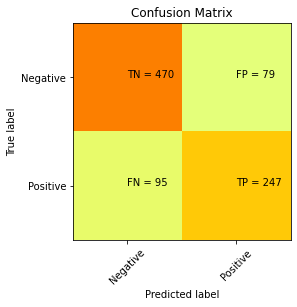

In [68]:
plt.clf()
plt.imshow(cm_log, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm_log[i][j]))
plt.show()

# K Nearest Neighbors 

In [69]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_x_train = scaler.fit_transform(X_train)
scaled_x_test = scaler.transform(X_test)

In [73]:
error_rate = []

# Will take some time
for i in range(1,20):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(scaled_x_train,Y_train)
    pred_i = knn.predict(scaled_x_test)
    error_rate.append(np.mean(pred_i != Y_test))

Text(0, 0.5, 'Error Rate')

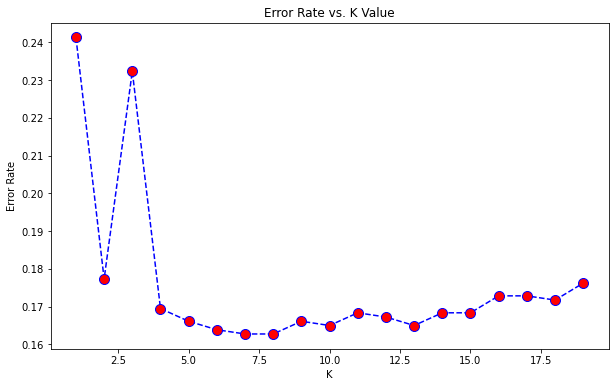

In [74]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [76]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(scaled_x_train,Y_train)
Y_pred_knn = knn.predict(scaled_x_test)
accuracy = round(knn.score(scaled_x_train,Y_train) * 100, 2)
print("Model Accuracy: ",accuracy)

Model Accuracy:  84.4


In [77]:
print("Accuracy is", accuracy_score(Y_test,Y_pred_knn)*100)

Accuracy is 83.38945005611671


In [78]:
cm_knn = confusion_matrix(Y_test,Y_pred_knn)
print(cm_knn)

[[476  73]
 [ 75 267]]


In [79]:
print(classification_report(Y_test,Y_pred_knn))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       549
           1       0.79      0.78      0.78       342

    accuracy                           0.83       891
   macro avg       0.82      0.82      0.82       891
weighted avg       0.83      0.83      0.83       891



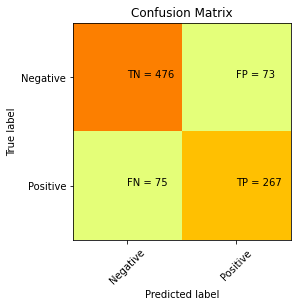

In [80]:
plt.clf()
plt.imshow(cm_knn, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm_knn[i][j]))
plt.show()

# Decision Tree

In [16]:
#Running our classifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred_dt = decision_tree.predict(X_test)
accuracy = round(decision_tree.score(X_train, Y_train) * 100, 2)
print("Model Accuracy: ",accuracy)

Model Accuracy:  87.32


In [32]:
print("Accuracy is", accuracy_score(Y_test,Y_pred_dt)*100)

Accuracy is 86.30751964085297


In [33]:
cm_dt = confusion_matrix(Y_test,Y_pred_dt)
print(cm_dt)

[[507  42]
 [ 80 262]]


In [34]:
print(classification_report(Y_test,Y_pred_dt))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       549
           1       0.86      0.77      0.81       342

    accuracy                           0.86       891
   macro avg       0.86      0.84      0.85       891
weighted avg       0.86      0.86      0.86       891



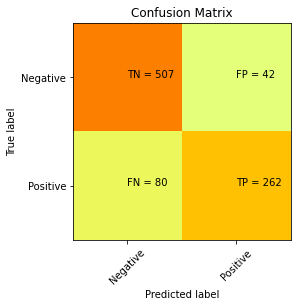

In [35]:
plt.clf()
plt.imshow(cm_dt, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm_dt[i][j]))
plt.show()

# Random Forest

In [36]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,Y_train)
Y_pred_rfc = rfc.predict(X_test)
accuracy = round(rfc.score(X_train, Y_train) * 100, 2)
print("Model Accuracy: ",accuracy)

Model Accuracy:  87.32


In [37]:
print("Accuracy is", accuracy_score(Y_test,Y_pred_rfc)*100)

Accuracy is 86.41975308641975


In [38]:
print(classification_report(Y_test,Y_pred_rfc))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       549
           1       0.86      0.77      0.81       342

    accuracy                           0.86       891
   macro avg       0.86      0.85      0.85       891
weighted avg       0.86      0.86      0.86       891



In [39]:
cm_rfc = confusion_matrix(Y_test,Y_pred_rfc)
print(cm_rfc)

[[507  42]
 [ 79 263]]


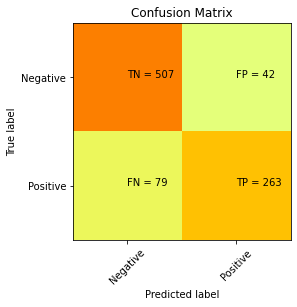

In [40]:
plt.clf()
plt.imshow(cm_rfc, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm_rfc[i][j]))
plt.show()

# Support Vector Machine

In [45]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train,Y_train) # If C is 0, we can have no margin kernel ='Radial Basis Functions'(Big cone located in all points of data set)
Y_pred_svm = svm.predict(X_test)
accuracy = round(svm.score(X_train, Y_train) * 100, 2)
print("Model Accuracy: ",accuracy)

Model Accuracy:  83.39


In [46]:
print("Accuracy is", accuracy_score(Y_test,Y_pred_svm)*100)

Accuracy is 83.27721661054994


In [47]:
print(classification_report(Y_test,Y_pred_svm))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       549
           1       0.84      0.70      0.76       342

    accuracy                           0.83       891
   macro avg       0.83      0.81      0.82       891
weighted avg       0.83      0.83      0.83       891



In [50]:
cm_svm = confusion_matrix(Y_test,Y_pred_svm)
print(cm_svm)

[[504  45]
 [104 238]]


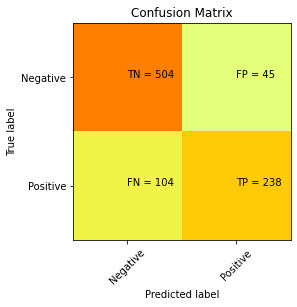

In [51]:
plt.clf()
plt.imshow(cm_svm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm_svm[i][j]))
plt.show()

# XGBoost

In [82]:
from xgboost import XGBClassifier
from xgboost import plot_importance

# fit model no training data
xgb = XGBClassifier()
xgb.fit(X_train, Y_train)
Y_pred_xgb = xgb.predict(X_test)
accuracy = round(xgb.score(X_train, Y_train) * 100, 2)
print("Model Accuracy: ",accuracy)

Model Accuracy:  87.09


[0.18090531 0.24298924 0.02815195 0.05780356 0.03441807 0.0440373
 0.41169462]


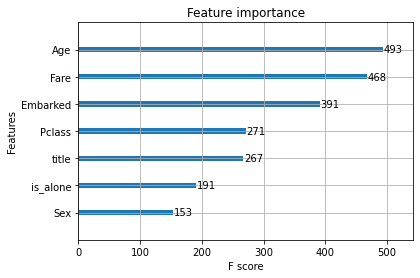

In [83]:
# feature importance
print(xgb.feature_importances_)
# plot feature importance
plot_importance(xgb)
plt.show()

In [84]:
print("Accuracy is", accuracy_score(Y_test,Y_pred_xgb)*100)

Accuracy is 86.08305274971941


In [85]:
print(classification_report(Y_test,Y_pred_xgb))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       549
           1       0.85      0.78      0.81       342

    accuracy                           0.86       891
   macro avg       0.86      0.85      0.85       891
weighted avg       0.86      0.86      0.86       891



In [86]:
cm_xgb = confusion_matrix(Y_test,Y_pred_xgb)
print(cm_xgb)

[[501  48]
 [ 76 266]]


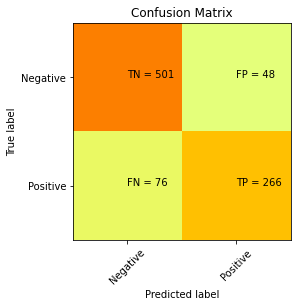

In [87]:
plt.clf()
plt.imshow(cm_xgb, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm_xgb[i][j]))
plt.show()

# ExtraTrees

In [89]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

etc.fit(X_train, Y_train)
Y_pred_etc = etc.predict(X_test)
accuracy = round(etc.score(X_train, Y_train) * 100, 2)
print("Model Accuracy: ",accuracy)

Model Accuracy:  87.32


In [90]:
print("Accuracy is", accuracy_score(Y_test,Y_pred_etc)*100)

Accuracy is 86.53198653198653


In [91]:
print(classification_report(Y_test,Y_pred_etc))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       549
           1       0.87      0.77      0.81       342

    accuracy                           0.87       891
   macro avg       0.87      0.85      0.85       891
weighted avg       0.87      0.87      0.86       891



In [92]:
cm_etc = confusion_matrix(Y_test,Y_pred_xgb)
print(cm_etc)

[[501  48]
 [ 76 266]]


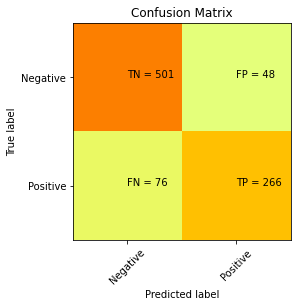

In [93]:
plt.clf()
plt.imshow(cm_etc, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm_etc[i][j]))
plt.show()

In [104]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

count_classes = Y_test.shape[1]
print(count_classes)

2


In [106]:
model = Sequential()
model.add(Dense(500, activation='relu', input_dim=7))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [108]:
# build the model
model.fit(X_train.values, Y_train, epochs=20)

Epoch 1/20
28/28 [==============================] - 0s 2ms/step - loss: 0.5551 - accuracy: 0.7464
Epoch 2/20
28/28 [==============================] - 0s 2ms/step - loss: 0.4842 - accuracy: 0.7688
Epoch 3/20
28/28 [==============================] - 0s 2ms/step - loss: 0.4564 - accuracy: 0.8047
Epoch 4/20
28/28 [==============================] - 0s 2ms/step - loss: 0.4440 - accuracy: 0.8002
Epoch 5/20
28/28 [==============================] - 0s 3ms/step - loss: 0.4390 - accuracy: 0.8114
Epoch 6/20
28/28 [==============================] - 0s 2ms/step - loss: 0.4319 - accuracy: 0.8070
Epoch 7/20
28/28 [==============================] - 0s 2ms/step - loss: 0.4417 - accuracy: 0.7980
Epoch 8/20
28/28 [==============================] - 0s 2ms/step - loss: 0.4151 - accuracy: 0.8193
Epoch 9/20
28/28 [==============================] - 0s 2ms/step - loss: 0.4201 - accuracy: 0.8137
Epoch 10/20
28/28 [==============================] - 0s 2ms/step - loss: 0.4201 - accuracy: 0.8103
Epoch 11/20
28/28 [

In [110]:
pred_train= model.predict(X_train.values)
scores = model.evaluate(X_train.values, Y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test= model.predict(X_test.values)
scores2 = model.evaluate(X_test.values, Y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    

Accuracy on training data: 0.8294051885604858% 
 Error on training data: 0.17059481143951416
Accuracy on test data: 0.8282828330993652% 
 Error on test data: 0.17171716690063477


In [111]:
#Create a CSV with results
submission = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": Y_pred_dt
})
submission.to_csv('submission.csv', index = False)